# b-end

In [25]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

from scipy.signal import butter, filtfilt, detrend
from scipy.signal.windows import tukey
import scipy.fftpack as fftpack
from obspy.signal import konnoohmachismoothing as sko

In [30]:
## Pre-processing
# Normalizing amplitude response for all component
def normamp(z, n, e):
    templis = []
    data = []
    templis.append(z.data), templis.append(n.data), templis.append(e.data)

    for x in range(len(templis)):
        for y in range(len(templis[x])):
            data.append(templis[x][y])
    
    xmin = min(data)
    xmax = max(data)
    
    Z = 2*((z-xmin)/(xmax-xmin))-1
    N = 2*((n-xmin)/(xmax-xmin))-1
    E = 2*((e-xmin)/(xmax-xmin))-1
    return Z, N, E
    
# Normalizing amplitude response for one component
def normoneamp(z):
    return 50*((z.data-min(z.data))/(max(z.data)-min(z.data)))-25 # normalize from-25 to -25

# # Normalizing amplitude response for one component: for trimmed data
# def normoneamp(z):
#     return 50*((z-min(z))/(max(z)-min(z)))-25 # normalize from-25 to -25
    
# Apply bandpass Butterworth filter to a time series
def bpfilter(normalizedamp, lc=0.5, hc=10, fs=100, order=5):
    fnyq = 0.5*fs
    
    # Create the filter coefficients
    b, a = butter(order,[lc/fnyq, hc/fnyq], btype='bandpass')
    # Apply the filter to your signal (replace 'signal' with your actual data)
    filt = filtfilt(b, a, normalizedamp, padlen=3*(max(len(b), len(a))-1))
    return filt

# Splitting the data
def split(filteredsignal, comp, windowlength, d=0.5, overlap=True):
    overlapp = overlap
    if overlapp == False:
        return np.split(filteredsignal, comp.stats.npts/(windowlength*comp.stats.sampling_rate))
    else:
        w = []
        for i in range(0, len(filteredsignal), round(windowlength*comp.stats.sampling_rate*(1-d))):
            w.append(filteredsignal[i:i+int(windowlength*comp.stats.sampling_rate)])
        while len(w[-1]) != windowlength*comp.stats.sampling_rate:
            del w[-1]
        return w

# Applying detrend filter
def d_trend(splitted):
    return detrend(splitted)

# Applying cosine taper to time series on individual component
def cosinetaper(detrended, width=0.1): # Geopsy default of 0.05 is equal to 0.1
    return detrended * tukey(len(detrended[0]), alpha=width) 
    # width `0` is equal to a rectangular and `1` a Hann window. 

# Preprocessing the signal
def preproallcomp(compZ, compN, compE, windowlength, width=0.1, lc=0.5, hc=10, fs=100, order=5, d=0.5, overlap=True):
    normZ, normN, normE = normamp(compZ, compN, compE)
    filtZ, filtN, filtE = bpfilter(normZ, lc, hc, fs, order), bpfilter(normN, lc, hc, fs, order), bpfilter(normE, lc, hc, fs, order)
    windZ, windN, windE = split(filtZ, compZ, windowlength, d), split(filtN, compN, windowlength, d), split(filtE, compE, windowlength, d)
    detrZ, detrN, detrE = d_trend(windZ), d_trend(windN), d_trend(windE)
    taprZ, taprN, taprE = cosinetaper(detrZ, width), cosinetaper(detrN, width), cosinetaper(detrE, width)

    onenormZ = normoneamp(compZ)
    ofiltZ = bpfilter(onenormZ, lc, hc, fs, order)
    owindZ = split(ofiltZ, compZ, windowlength, d)
    odetrZ = d_trend(owindZ)
    otaprZ = cosinetaper(odetrZ, width)
    return taprZ, taprN, taprE, otaprZ

## Processing Data    
# Performing fast fourier transfrom (fft) and get the value 
def makefft(preprodata, npts, nfrqs):
    fft, slicedfft = np.empty(shape=[len(preprodata), npts]), np.empty(shape=[len(preprodata), nfrqs])

    for i in range(len(preprodata)):
        fft[i] = 2/npts*np.abs(fftpack.fft(preprodata[i]))
        slicedfft[i] = fft[i][:nfrqs]
    return slicedfft

# Performing power spectral density (psd) and get the value 
def makepsd(preprodata, npts, nfrqs, dt):
    psd, slicedpsd = np.empty(shape=[len(preprodata), npts]), np.empty(shape=[len(preprodata), nfrqs])
    
    for iter in range(len(preprodata)):
        psd[iter] = (np.abs(fftpack.fft(preprodata[iter])))**2/(npts*1/dt)
        slicedpsd[iter] = psd[iter][:nfrqs]
    return slicedpsd

# Sliding Window Technique for Signal Stacking
def signal_stack(slicedlist):
    coplist = slicedlist.copy()
    base, wstart = 0, 1
    
    for wstart in range(len(coplist)):
        coplist[base] += coplist[wstart]
        coplist[base] / 2
        wstart += 1
    return coplist[base]

# Averaging Technique (Geopsy)
def signal_avg(slicedlist, mode="median"):
    #coplist = slicedlist.copy()
    #base, wstart = 0, 1
    
    #for wstart in range(len(coplist)):
    #    coplist[base] += coplist[wstart]
    #    wstart += 1
    #mean = coplist[base]/len(coplist)    
    #return mean
    if mode == "median":
        medlist = np.median(slicedlist, axis=0)
        return medlist
    elif mode == "mean":
        meanlist = np.mean(slicedlist, axis=0)
        return meanlist
    else:
        msg = "Method isn't implemented yet."
        raise Exception(msg)

# Splitting, Performing FFT and PSD, Stacking or Averaging for each component
def fftpsd(preprodata, npts, nfrqs, dt, preprodata2=None, make_psd=False):
    if make_psd == False:
        fft = makefft(preprodata, npts, nfrqs)
        avg = signal_avg(fft, mode="median")
        return fft, avg
    else: # then make psd
        # fft
        fft = makefft(preprodata, npts, nfrqs)
        avgfft = signal_avg(fft, mode="median")

        # psd
        psd = makepsd(preprodata2, npts, nfrqs, dt)
        avgpsd = signal_avg(psd, mode="median")
        return fft, psd, avgfft, avgpsd

# Combining horizontal component
def combhor(n, e, method="geom-mean"):
    if method == "geom-mean":
        horgm = np.sqrt(n * e)
        return horgm
    elif method == "sqrd-avg":
        horsa = np.sqrt((n*n + e*e)/2)
        return horsa
    else:
        msg = "Method isn't implemented yet."
        raise Exception(msg)

# Performing VHSR or HVSR
def spectralratio(compZ, compN, compE, combinemethod="geom-mean", make_vhsr=True, smooth_ko=True):
    horizontal = combhor(compN, compE, combinemethod)
    vertical = compZ.copy()
    smoothver = sko.konno_ohmachi_smoothing(vertical, frq, normalize=True)
    smoothhor = sko.konno_ohmachi_smoothing(horizontal, frq, normalize=True)
    std = []
    
    if make_vhsr == True:
        if smooth_ko == True:
            smoothvhsr = smoothver / smoothhor
            for i in range(len(smoothvhsr[0])):
                std_c = np.std(smoothvhsr[:,i])
                std.append(std_c)
            return smoothvhsr, std
        else:
            vhsr = vertical / horizontal
            for i in range(len(vhsr[0])):
                std_c = np.std(vhsr[:,i])
                std.append(std_c)
            return vhsr, std
    else: # then make hvsr
        if smooth_ko == True:
            smoothhvsr = smoothhor / smoothver
            for i in range(len(smoothhvsr[0])):
                std_c = np.std(smoothhvsr[:,i])
                std.append(std_c)
            return smoothhvsr, std
        else:
            hvsr = horizontal / vertical
            for i in range(len(hvsr[0])):
                std_c = np.std(hvsr[:,i])
                std.append(std_c)            
            return hvsr, std

# Resampling
def make_zero(spektrum, freq, aa, bb):
    copii = spektrum.copy()
    
    frqaa = freq.tolist().index(aa)
    frqbb = freq.tolist().index(bb)
    
    for i in range(0, int(frqaa)):
        copii[:,i] = 0
    for j in range(int(frqbb)+1, len(copii[0])):
        copii[:,j] = 0
    return copii

# Calculate Integral Area VHSR
def f(x):
    return x/x

def customf(spectral, freq, minf=1, maxf=6):
    frqminf = freq.tolist().index(minf)
    frqmaxf = freq.tolist().index(maxf)
    emptlist = []

    for i in range(frqminf,frqmaxf):
        if spectral[i] < 1.0:
            emptlist.append(1.0)
        else:
            emptlist.append(spectral[i])
    return emptlist

def integral_area_vhsr(spectral, freq, minf=1, maxf=6):
    frqminf = freq.tolist().index(minf)
    frqmaxf = freq.tolist().index(maxf)
    
    integral = np.trapz(customf(spectral, freq), freq[frqminf:frqmaxf]) - np.trapz(f(freq[frqminf:frqmaxf]), freq[frqminf:frqmaxf])
    return integral

# Calculate Integral Area PSD
def integral_area_psd(spectral, freq, minf=1, maxf=4):
    frqminf = freq.tolist().index(minf)
    frqmaxf = freq.tolist().index(maxf)
    integral = np.trapz(spectral[frqminf:frqmaxf], freq[frqminf:frqmaxf])
    return integral

In [27]:
# Frequency-domain Window-rejection
# Skip zero values
def skip_zero(list):
    return list[~np.all(list == 0, axis=1)]

# Factory: Calculate mean values
def mean_factory(values, cond):
    return np.mean(values, where=cond)

# Factory: Calculate standard deviation values
def std_factory(values, cond):
    return np.std(values, ddof=1, where=cond)

# Factory: Calculate standard deviation values from the mean of each peak window/spectra
def nth_std_factory(n, mean, std):
    return (mean + n*std)

# Searching peak frequency for each window/spectra
def peak_search_frq(val, frq):
    peak=[]
    for i in range(len(val)):
        peakw = frq[val[i].tolist().index(max(val[i]))]
        peak.append(peakw)
    return peak

# Calculate mean values
def mean_f0_frq(val, frq, cond):
    peak = peak_search_frq(val, frq)
    return mean_factory(peak, cond)

# Calculate standard deviation values
def std_f0_frq(val, frq, cond):
    peak = peak_search_frq(val, frq)
    return std_factory(peak, cond)

# Searching peak frequency of mean curve
def mc_peak_frq(allwindow):
    cop = []
    skip = skip_zero(allwindow)

    if len(skip) == 0:
        raise Exception('All window is rejected. Please check your data again, or raise the value of n.')
    else:
        for i in range(len(skip[0])):
            mean = np.mean(skip[:,i])
            cop.append(mean)
    
    max_mean = max(cop)
    max_mean_frq = frq[cop.index(max_mean)]
    return max_mean_frq

# Frequency-domain window-rejection algorithm
def fdwr(vhsrallwindow, frq, n=2, max_iter=50): # fa=1, fb=6,
    start_window = vhsrallwindow.copy()
    
    for c_iter in range(1, max_iter+1):        
        iter_window = skip_zero(start_window)
        valid_indices = np.ones(len(iter_window), dtype=bool)
        
        # defining beginning params
        mean_f0_b = mean_f0_frq(iter_window, frq, valid_indices)
        std_f0_b = std_f0_frq(iter_window, frq, valid_indices)
        mc_peak_frq_b = mc_peak_frq(iter_window)
        d_b = abs(mean_f0_b - mc_peak_frq_b)

        lower_bound = nth_std_factory(-n, mean_f0_b, std_f0_b)
        upper_bound = nth_std_factory(+n, mean_f0_b, std_f0_b)
        
        
        peak = peak_search_frq(iter_window, frq)
        for i in range(len(valid_indices)):
            if not peak[i] > lower_bound or not peak[i] < upper_bound:
                valid_indices[i] = False
            if valid_indices[i] == False:
                iter_window[i] = np.zeros(len(iter_window[i]))
        

        mean_f0_aft = mean_f0_frq(iter_window, frq, valid_indices)
        std_f0_aft = std_f0_frq(iter_window, frq, valid_indices)
        mc_peak_frq_aft = mc_peak_frq(iter_window)
        d_aft = abs(mean_f0_aft - mc_peak_frq_aft)
        
        d_diff = abs(d_aft - d_b)/d_b
        s_diff = abs(std_f0_aft - std_f0_b)

        del start_window
        start_window = iter_window
        #print("Iteration-{}: Initial Windows = {}, Remaining Windows = {}, Windows Rejected = {}".format(c_iter, len(start_window), np.count_nonzero(valid_indices),
        #                                                                                                 len(start_window)-np.count_nonzero(valid_indices)))
        
        final_window = skip_zero(iter_window)
        final_mean = []
        final_std = []
        
        for i in range(len(final_window[0])):
            mean_c = np.mean(final_window[:,i])
            std_c = np.std(final_window[:,i])
            final_mean.append(mean_c)
            final_std.append(std_c)
        
        if d_b == 0 or std_f0_b == 0 or std_f0_aft == 0:
            print("Performed {} iterations, returning b/c 0 values".format(c_iter))
            return final_window, np.array(final_mean), final_std, mean_f0_aft, std_f0_aft, n, np.count_nonzero(valid_indices)
        
        if (d_diff < 0.01) and (s_diff < 0.01):
            print("Performed {} iterations, returning b/c rejection converged".format(c_iter))
            return final_window, np.array(final_mean), final_std, mean_f0_aft, std_f0_aft, n, np.count_nonzero(valid_indices)

        if c_iter == max_iter:
            print("Ouch! didn't pass the stopping criteria 'til the end of iteration. Check your data!")
            return final_window, np.array(final_mean), final_std, mean_f0_aft, std_f0_aft, n, np.count_nonzero(valid_indices)

# 1 data check

In [596]:
# 1 data check
traces = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi2/70_MJ_230826_17-23.mseed", format="MSEED")

Z = traces[0]
N = traces[1]
E = traces[2]
        
window_length = 60 #in seconds
        
dt = Z.stats.delta #only need one bcs all trace should be the same value
npts = int(window_length*Z.stats.sampling_rate) #amp_windowZ[0].shape[-1] #only need one bcs all trace should be the same value #length of the sample in one window
nfrqs = int(npts/2) #only need one bcs all trace should be the same value
frq = np.abs(np.fft.fftfreq(npts, dt))[:nfrqs] #only need one bcs all trace should be the same value
        
# Preprocess data
prepZ, prepN, prepE, oneprepZ = preproallcomp(Z, N, E, window_length, d=0.5, overlap=True)
        
# Performing FFT on each component and PSD only for Z component
fftZ, psdZ, fftZavg, psdZavg = fftpsd(prepZ, npts, nfrqs, dt, oneprepZ, make_psd=True)
fftN, fftNavg = fftpsd(prepN, npts, nfrqs, dt)
fftE, fftEavg = fftpsd(prepE, npts, nfrqs, dt)
        
# Performing VHSR / alternative VHSR with smoothing konno ohmachi
#vhsr, stdvhsr = spectralratio(fftZ, fftN, fftE, smooth_ko = False)
vhsrsmooth, stdvhsr = spectralratio(fftZ, fftN, fftE)
vhsrsmooth_zerod = make_zero(vhsrsmooth, frq, 0.5, 10)
avgvhsr = signal_avg(vhsrsmooth_zerod, mode="median")
        
# Applying Konno-Ohmachi Smoothing for PSD
smoothpsd = sko.konno_ohmachi_smoothing(psdZ, frq, normalize=True)
stdpsd = []
for i in range(len(smoothpsd[0])):
    std_c = np.std(smoothpsd[:,i])
    stdpsd.append(std_c)
avgpsd = signal_avg(smoothpsd, mode="median")

# Statisctial calculation before rejection plotting vhsr and psd
vhsr_before_meanf0 = mean_f0_frq(vhsrsmooth_zerod, frq, np.ones(len(vhsrsmooth_zerod), dtype=bool))
vhsr_before_stdf0 = std_f0_frq(vhsrsmooth_zerod, frq, np.ones(len(vhsrsmooth_zerod), dtype=bool))
psd_before_meanf0 = mean_f0_frq(smoothpsd, frq, np.ones(len(smoothpsd), dtype=bool))
psd_before_stdf0 = std_f0_frq(smoothpsd, frq, np.ones(len(smoothpsd), dtype=bool))

# Integral area calculation of desired range; before rejection
#intvhsr = integral_area_vhsr(vhsr, frq)
smoothintvhsr_bfr = integral_area_vhsr(avgvhsr, frq)
#psdiz = integral_area_psd(psdZ, frq)
smoothpsdiz_bfr = integral_area_psd(avgpsd, frq)

In [603]:
vhsr_rejectwindow, vhsr_meancurve, vhsr_stdcurve, vhsr_meanf0, vhsr_stdf0, nvhsr, accvhsr = fdwr(vhsrsmooth_zerod, frq,
n=2.2, max_iter=50) #, n=2, max_iter=50

# Integral area calculation of desired range; after rejection
smoothintvhsr_aft = integral_area_vhsr(vhsr_meancurve, frq)

Iteration-1: Initial Windows = 719, Remaining Windows = 667, Windows Rejected = 52
Iteration-2: Initial Windows = 667, Remaining Windows = 634, Windows Rejected = 33
Iteration-3: Initial Windows = 634, Remaining Windows = 586, Windows Rejected = 48
Iteration-4: Initial Windows = 586, Remaining Windows = 564, Windows Rejected = 22
Iteration-5: Initial Windows = 564, Remaining Windows = 542, Windows Rejected = 22
Iteration-6: Initial Windows = 542, Remaining Windows = 532, Windows Rejected = 10
Iteration-7: Initial Windows = 532, Remaining Windows = 526, Windows Rejected = 6
Iteration-8: Initial Windows = 526, Remaining Windows = 523, Windows Rejected = 3
Iteration-9: Initial Windows = 523, Remaining Windows = 523, Windows Rejected = 0
Performed 9 iterations, returning b/c rejection converged


In [604]:
psd_rejectwindow, psd_meancurve, psd_stdcurve, psd_meanf0, psd_stdf0, npsd, accpsd = fdwr(smoothpsd, frq,
n=2.2, max_iter=50) #, n=2, max_iter=50

# Integral area calculation of desired range; after rejection
smoothpsdiz_aft = integral_area_psd(psd_meancurve, frq)

Iteration-1: Initial Windows = 719, Remaining Windows = 677, Windows Rejected = 42
Iteration-2: Initial Windows = 677, Remaining Windows = 651, Windows Rejected = 26
Iteration-3: Initial Windows = 651, Remaining Windows = 611, Windows Rejected = 40
Iteration-4: Initial Windows = 611, Remaining Windows = 576, Windows Rejected = 35
Iteration-5: Initial Windows = 576, Remaining Windows = 550, Windows Rejected = 26
Iteration-6: Initial Windows = 550, Remaining Windows = 532, Windows Rejected = 18
Iteration-7: Initial Windows = 532, Remaining Windows = 513, Windows Rejected = 19
Iteration-8: Initial Windows = 513, Remaining Windows = 500, Windows Rejected = 13
Iteration-9: Initial Windows = 500, Remaining Windows = 492, Windows Rejected = 8
Performed 9 iterations, returning b/c rejection converged


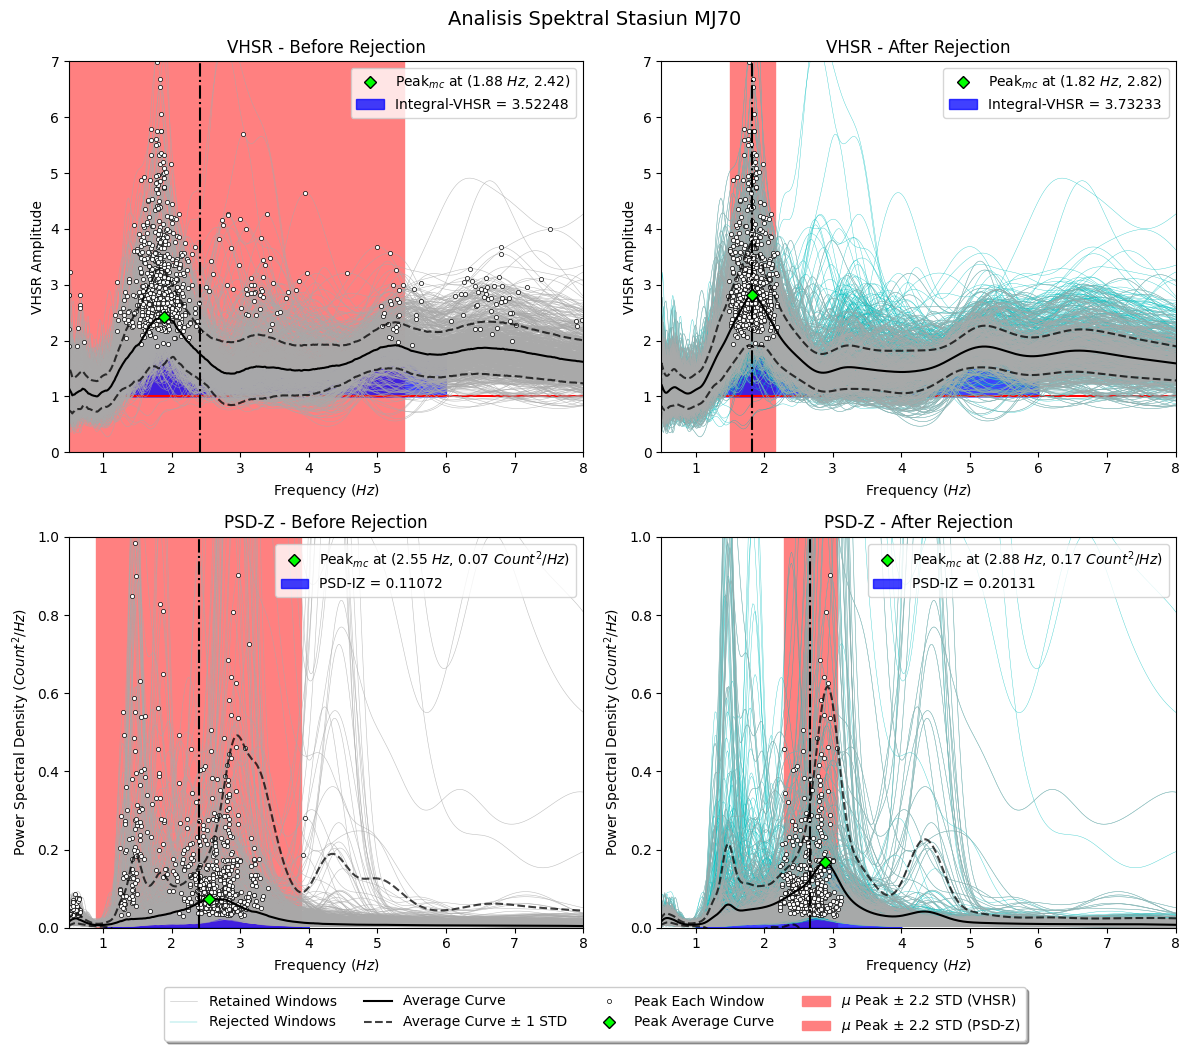

3.7323318979565707 , 2.8225407810186525 , 1.8166666666666667 , 0.20130556818753403 , 0.16699966116321616 , 2.8833333333333333 , 523 , 492


In [605]:
# Set range for plotting
ymin, ymax_vh, ymax_psd = 0, 7, 1

# Limiting the Peak, IF the peak is out of the interest range
bb, bavh, bapsd  = 1, 6, 4 #hz
frqbb, frqbavh, frqbapsd = frq.tolist().index(bb), frq.tolist().index(bavh), frq.tolist().index(bapsd)

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

#region plot1
# Plot Before Rejection
# Plot Lower Boundary of Integral VHSR 
ax1.hlines([1], xmin=0, xmax=10, color="r")

# Plot Retained
for i in range(len(vhsrsmooth_zerod)): #len(vhsrsmooth_zerod)
    ax1.plot(frq, vhsrsmooth_zerod[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"

# Plot f_0 Retained
for i in range(len(vhsrsmooth_zerod)): #len(vhsrsmooth_zerod)
    ax1.plot(frq[vhsrsmooth_zerod[i].tolist().index(max(vhsrsmooth_zerod[i]))], max(vhsrsmooth_zerod[i]), linestyle="", zorder=2, marker='o',
             markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'

# Plot Mean f_0, Mean f_0 ± STD
ax1.plot([vhsr_before_meanf0]*2, [ymin, ymax_vh], 'k-.')
ax1.fill([vhsr_before_meanf0-(2*vhsr_before_stdf0)]*2 + [vhsr_before_meanf0+(2*vhsr_before_stdf0)]*2, [ymin, ymax_vh, ymax_vh, ymin], color = "#ff8080") #, label="$μ_{f0}$ ± 2 STD"

# Plot Mean Curve, Mean Curve ± STD
ax1.plot(frq, avgvhsr, 'k') #, label="Mean Curve"
ax1.plot(frq, avgvhsr-stdvhsr, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
ax1.plot(frq, avgvhsr+stdvhsr, 'k--', alpha=0.75)

# Plot Mean Curve f_0
ax1.plot(frq[avgvhsr.tolist().index(max(avgvhsr))], max(avgvhsr), linestyle="", marker='D', markersize=6,
         markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
         label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f})".format("{mc}", frq[avgvhsr.tolist().index(max(avgvhsr))], max(avgvhsr))) #= {:.2f}'.format(max(avgvhsr))

if avgvhsr.tolist().index(max(avgvhsr))<frqbb or avgvhsr.tolist().index(max(avgvhsr))>frqbavh:
    ax1.plot(frq[avgvhsr.tolist().index(max(avgvhsr[frqbb:frqbavh]))], max(avgvhsr[frqbb:frqbavh]), linestyle="", marker='D', markersize=6,
             markerfacecolor='gold', markeredgewidth=1, markeredgecolor='k',
             label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f})".format("{mc2}", frq[avgvhsr.tolist().index(max(avgvhsr[frqbb:frqbavh]))], max(avgvhsr[frqbb:frqbavh]))) #= {:.2f}'.format(max(avgvhsr))

# Plot Integral VHSR
ax1.fill_between(frq, 1, avgvhsr, color="b", label='Integral-VHSR = {:.5f}'.format(smoothintvhsr_bfr), where=(avgvhsr>=1)&(frq>=1)&(frq<=6), alpha=0.75)

# Plot Legend for this axis
ax1.legend(loc="upper right")
#end region plot1

#region plot2
# Plot After Rejection
# Plot Lower Boundary of Integral VHSR 
ax2.hlines([1], xmin=0, xmax=10, color="r")

# Plot Rejected
for i in range(len(vhsrsmooth_zerod)): #len(vhsrsmooth_zerod)
    if i == 0:
        fl2, = ax2.plot(frq, vhsrsmooth_zerod[i], "c", alpha=0.75, lw=0.3) #color="silver" , label="Rejected Windows"
    else:
        ax2.plot(frq, vhsrsmooth_zerod[i], "c", alpha=0.75, lw=0.3)

# Plot Retained
for i in range(len(vhsr_rejectwindow)): #len(vhsrsmooth_zerod)
    if i == 0:
        fl1, = ax2.plot(frq, vhsr_rejectwindow[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"
    else:
        ax2.plot(frq, vhsr_rejectwindow[i], color="darkgray", alpha=0.75, lw=0.4)

# Plot f_0 Retained
for i in range(len(vhsr_rejectwindow)): #len(vhsr_rejectwindow)
    if i == 0:
        fl5, = ax2.plot(frq[vhsr_rejectwindow[i].tolist().index(max(vhsr_rejectwindow[i]))], max(vhsr_rejectwindow[i]), linestyle="", zorder=2, marker='o',
                 markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'
    else:
        ax2.plot(frq[vhsr_rejectwindow[i].tolist().index(max(vhsr_rejectwindow[i]))], max(vhsr_rejectwindow[i]), linestyle="", zorder=2, marker='o',
                 markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k')

# Plot Mean f_0, Mean f_0 ± STD
ax2.plot([vhsr_meanf0]*2, [ymin, ymax_vh], 'k-.')
fl7, = ax2.fill([vhsr_meanf0-(2*vhsr_stdf0)]*2 + [vhsr_meanf0+(2*vhsr_stdf0)]*2, [ymin, ymax_vh, ymax_vh, ymin], color = "#ff8080") #, label="$μ$ Peak ± {} STD".format(nvhsr)

# Plot Mean Curve, Mean Curve ± STD
fl3, = ax2.plot(frq, vhsr_meancurve, 'k') #, label="Mean Curve"
fl4, = ax2.plot(frq, vhsr_meancurve-vhsr_stdcurve, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
ax2.plot(frq, vhsr_meancurve+vhsr_stdcurve, 'k--', alpha=0.75)

# Plot Mean Curve f_0
fl6, = ax2.plot(frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve))], max(vhsr_meancurve), linestyle="", marker='D', markersize=6,
                markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
                label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f})".format("{mc}", frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve))], max(vhsr_meancurve)))
                #= {:.2f}'.format(max(vhsr_meancurve))

if vhsr_meancurve.tolist().index(max(vhsr_meancurve))<frqbb or vhsr_meancurve.tolist().index(max(vhsr_meancurve))>frqbavh:
    ax2.plot(frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve[frqbb:frqbavh]))], max(vhsr_meancurve[frqbb:frqbavh]), linestyle="", marker='D', markersize=6,
             markerfacecolor='gold', markeredgewidth=1, markeredgecolor='k',
             label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f})".format("{mc2}", frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve[frqbb:frqbavh]))], max(vhsr_meancurve[frqbb:frqbavh]))) #= {:.2f}'.format(max(avgvhsr))

# Plot Integral VHSR
ax2.fill_between(frq, 1, vhsr_meancurve, color="b", label='Integral-VHSR = {:.5f}'.format(smoothintvhsr_aft), where=(vhsr_meancurve>=1)&(frq>=1)&(frq<=6), alpha=0.75)

# Plot Legend for this axis
ax2.legend(loc="upper right")
#end region plot2

#region plot3
# Plot Before Rejection
# Plot Retained
for i in range(len(smoothpsd)): #len(smoothpsd)
    ax3.plot(frq, smoothpsd[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"

# Plot f_0 Retained
for i in range(len(smoothpsd)): #len(smoothpsd)
    ax3.plot(frq[smoothpsd[i].tolist().index(max(smoothpsd[i]))], max(smoothpsd[i]), linestyle="", zorder=2, marker='o',
             markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'

# Plot Mean f_0, Mean f_0 ± STD
ax3.plot([psd_before_meanf0]*2, [ymin, ymax_psd], 'k-.')
ax3.fill([psd_before_meanf0-(2*psd_before_stdf0)]*2 + [psd_before_meanf0+(2*psd_before_stdf0)]*2, [ymin, ymax_psd, ymax_psd, ymin], color = "#ff8080") #, label="$μ_{f0}$ ± 2 STD"

# Plot Mean Curve, Mean Curve ± STD
ax3.plot(frq, avgpsd, 'k') #, label="Mean Curve"
ax3.plot(frq, avgpsd-stdpsd, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
ax3.plot(frq, avgpsd+stdpsd, 'k--', alpha=0.75)

# Plot Mean Curve f_0
ax3.plot(frq[avgpsd.tolist().index(max(avgpsd))], max(avgpsd), linestyle="", marker='D', markersize=6,
         markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
         label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f} $Count^2/Hz$)".format("{mc}", frq[avgpsd.tolist().index(max(avgpsd))], max(avgpsd))) #= {:.2f}'.format(max(avgpsd))

if avgpsd.tolist().index(max(avgpsd))<frqbb or avgpsd.tolist().index(max(avgpsd))>frqbapsd:
    ax3.plot(frq[avgpsd.tolist().index(max(avgpsd[frqbb:frqbapsd]))], max(avgpsd[frqbb:frqbapsd]), linestyle="", marker='D', markersize=6,
             markerfacecolor='gold', markeredgewidth=1, markeredgecolor='k',
             label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f} $Count^2/Hz$)".format("{mc2}", frq[avgpsd.tolist().index(max(avgpsd[frqbb:frqbapsd]))], max(avgpsd[frqbb:frqbapsd]))) #= {:.2f}'.format(max(avgvhsr))

# Plot Integral PSD-Z
ax3.fill_between(frq, 0, avgpsd, color="b", label='PSD-IZ = {:.5f}'.format(smoothpsdiz_bfr), where=(avgpsd>=0)&(frq>=1)&(frq<=4), alpha=0.75)

# Plot Legend for this axis
ax3.legend(loc="upper right")
#end region plot3

#region plot4
# Plot After Rejection
# Plot Rejected
for i in range(len(smoothpsd)): #len(smoothpsd)
    ax4.plot(frq, smoothpsd[i], "c", alpha=0.75, lw=0.3) #color="silver" , label="Rejected Windows"
    
# Plot Retained
for i in range(len(psd_rejectwindow)): #len(psd_rejectwindow)
    ax4.plot(frq, psd_rejectwindow[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"

# Plot f_0 Retained
for i in range(len(psd_rejectwindow)): #len(psd_rejectwindow)
    ax4.plot(frq[psd_rejectwindow[i].tolist().index(max(psd_rejectwindow[i]))], max(psd_rejectwindow[i]), linestyle="", zorder=2, marker='o',
             markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'

# Plot Mean f_0, Mean f_0 ± STD
ax4.plot([psd_meanf0]*2, [ymin, ymax_psd], 'k-.')
fl8, = ax4.fill([psd_meanf0-(2*psd_stdf0)]*2 + [psd_meanf0+(2*psd_stdf0)]*2, [ymin, ymax_psd, ymax_psd, ymin], color = "#ff8080") #, label="$μ$ Peak ± {} STD".format(npsd)

# Plot Mean Curve, Mean Curve ± STD
ax4.plot(frq, psd_meancurve, 'k') #, label="Mean Curve"
ax4.plot(frq, psd_meancurve-psd_stdcurve, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
ax4.plot(frq, psd_meancurve+psd_stdcurve, 'k--', alpha=0.75)

# Plot Mean Curve f_0
ax4.plot(frq[psd_meancurve.tolist().index(max(psd_meancurve))], max(psd_meancurve), linestyle="", marker='D', markersize=6,
         markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
         label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f} $Count^2/Hz$)".format("{mc}", frq[psd_meancurve.tolist().index(max(psd_meancurve))], max(psd_meancurve)))
         #= {:.2f}'.format(max(psd_meancurve)) 

if psd_meancurve.tolist().index(max(psd_meancurve))<frqbb or psd_meancurve.tolist().index(max(psd_meancurve))>frqbapsd:
    ax4.plot(frq[psd_meancurve.tolist().index(max(psd_meancurve[frqbb:frqbapsd]))], max(psd_meancurve[frqbb:frqbapsd]), linestyle="", marker='D', markersize=6,
             markerfacecolor='gold', markeredgewidth=1, markeredgecolor='k',
             label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f} $Count^2/Hz$)".format("{mc2}", frq[psd_meancurve.tolist().index(max(psd_meancurve[frqbb:frqbapsd]))], max(psd_meancurve[frqbb:frqbapsd]))) #= {:.2f}'.format(max(avgvhsr))

# Plot Integral PSD-Z
ax4.fill_between(frq, 0, psd_meancurve, color="b", label='PSD-IZ = {:.5f}'.format(smoothpsdiz_aft), where=(psd_meancurve>=0)&(frq>=1)&(frq<=4), alpha=0.75)

# Plot Legend for this axis
ax4.legend(loc="upper right")
#end region plot4

#region limiting plot
ax1.set_xlim(0.5,8), ax2.set_xlim(0.5,8), ax3.set_xlim(0.5,8), ax4.set_xlim(0.5,8)
ax1.set_ylim(ymin,ymax_vh), ax2.set_ylim(ymin,ymax_vh), ax3.set_ylim(ymin,ymax_psd), ax4.set_ylim(ymin,ymax_psd)
#end region limiting plot

#region label axis
ax1.set_xlabel("Frequency ($Hz$)"), ax2.set_xlabel("Frequency ($Hz$)"), ax3.set_xlabel("Frequency ($Hz$)"), ax4.set_xlabel("Frequency ($Hz$)")
ax1.set_ylabel("VHSR Amplitude"), ax2.set_ylabel("VHSR Amplitude"),
ax3.set_ylabel("Power Spectral Density ($Count^2/Hz$)"), ax4.set_ylabel("Power Spectral Density ($Count^2/Hz$)")
#end region label axis

#region title axis
ax1.set_title('VHSR - Before Rejection'), ax2.set_title('VHSR - After Rejection'), ax3.set_title('PSD-Z - Before Rejection'), ax4.set_title('PSD-Z - After Rejection')
#end region title axis

fig.suptitle("Analisis Spektral Stasiun MJ{}".format(Z.stats.station), fontsize = 14)
fig.legend([fl1, fl2, fl3, fl4, fl5, fl6, fl7, fl8], ["Retained Windows", "Rejected Windows", "Average Curve", "Average Curve ± 1 STD",
                                                 "Peak Each Window", "Peak Average Curve", "$μ$ Peak ± {} STD (VHSR)".format(nvhsr), "$μ$ Peak ± {} STD (PSD-Z)".format(npsd)],
           loc='upper center', bbox_to_anchor=(0.5, 0.01), shadow=True, ncol=4)
#fig.gca().add_artist(mainlegend)
fig.tight_layout()

plt.savefig("Stasiun MJ{}-Analisis Spektral-FDWR.png".format(Z.stats.station), bbox_inches='tight')
plt.show()

print(smoothintvhsr_aft, ',', max(vhsr_meancurve[frqbb:frqbavh]), ',', frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve[frqbb:frqbavh]))],
      ',', smoothpsdiz_aft, ',', max(psd_meancurve[frqbb:frqbapsd]), ',', frq[psd_meancurve.tolist().index(max(psd_meancurve[frqbb:frqbapsd]))],
      ',', accvhsr, ',', accpsd)

# 5 data check

In [10]:
st = time.time()
directory = 'C:/Users/PC-MSI/Downloads/RawDataSkripsi/Different Day Compare/datalimahari2'

for folder in os.listdir(directory):
    filelist = []
    for i in os.listdir(os.path.join(directory, folder)):
        filelist.append(i)
    
    fname, fname1, fname2, fname3, fname4 = filelist
    traces = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi/Different Day Compare/datalimahari2/{}/{}".format(folder, fname), format="MSEED")
    traces1 = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi/Different Day Compare/datalimahari2/{}/{}".format(folder, fname1), format="MSEED")
    traces2 = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi/Different Day Compare/datalimahari2/{}/{}".format(folder, fname2), format="MSEED")
    traces3 = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi/Different Day Compare/datalimahari2/{}/{}".format(folder, fname3), format="MSEED")
    traces4 = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi/Different Day Compare/datalimahari2/{}/{}".format(folder, fname4), format="MSEED")

    Z, N, E = traces[0], traces[1], traces[2]
    Z1, N1, E1 = traces1[0], traces1[1], traces1[2]
    Z2, N2, E2 = traces2[0], traces2[1], traces2[2]
    Z3, N3, E3 = traces3[0], traces3[1], traces3[2]
    Z4, N4, E4 = traces4[0], traces4[1], traces4[2]

    window_length = [60] #in seconds
    ovr = 0.5

    for j in window_length:
        dt = Z.stats.delta #only need one bcs all trace should be the same value
        npts = int(j*Z.stats.sampling_rate) #amp_windowZ[0].shape[-1] #only need one bcs all trace should be the same value #length of the sample in one window
        nfrqs = int(npts/2) #only need one bcs all trace should be the same value
        frq = np.abs(np.fft.fftfreq(npts, dt))[:nfrqs] #only need one bcs all trace should be the same value
    
        # Preprocess data
        prepZ, prepN, prepE, oneprepZ = preproallcomp(Z, N, E, j, d=ovr) # , overlap=False
        prepZ1, prepN1, prepE1, oneprepZ1 = preproallcomp(Z1, N1, E1, j, d=ovr)
        prepZ2, prepN2, prepE2, oneprepZ2 = preproallcomp(Z2, N2, E2, j, d=ovr)
        prepZ3, prepN3, prepE3, oneprepZ3 = preproallcomp(Z3, N3, E3, j, d=ovr)
        prepZ4, prepN4, prepE4, oneprepZ4 = preproallcomp(Z4, N4, E4, j, d=ovr)
    
        # Performing FFT on each component and PSD only for Z component
        fftZ, psdZ, fftZstk, psdZstk = fftpsd(prepZ, npts, nfrqs, dt, oneprepZ, make_psd=True)
        fftN, fftNstk = fftpsd(prepN, npts, nfrqs, dt)
        fftE, fftEstk = fftpsd(prepE, npts, nfrqs, dt)
    
        fftZ1, psdZ1, fftZ1stk, psdZ1stk = fftpsd(prepZ1, npts, nfrqs, dt, oneprepZ1, make_psd=True)
        fftN1, fftN1stk = fftpsd(prepN1, npts, nfrqs, dt)
        fftE1, fftE1stk = fftpsd(prepE1, npts, nfrqs, dt)
        
        fftZ2, psdZ2, fftZ2stk, psdZ2stk = fftpsd(prepZ2, npts, nfrqs, dt, oneprepZ2, make_psd=True)
        fftN2, fftN2stk = fftpsd(prepN2, npts, nfrqs, dt)
        fftE2, fftE2stk = fftpsd(prepE2, npts, nfrqs, dt)
        
        fftZ3, psdZ3, fftZ3stk, psdZ3stk = fftpsd(prepZ3, npts, nfrqs, dt, oneprepZ3, make_psd=True)
        fftN3, fftN3stk = fftpsd(prepN3, npts, nfrqs, dt)
        fftE3, fftE3stk = fftpsd(prepE3, npts, nfrqs, dt)
        
        fftZ4, psdZ4, fftZ4stk, psdZ4stk = fftpsd(prepZ4, npts, nfrqs, dt, oneprepZ4, make_psd=True)
        fftN4, fftN4stk = fftpsd(prepN4, npts, nfrqs, dt)
        fftE4, fftE4stk = fftpsd(prepE4, npts, nfrqs, dt)

        # Performing VHSR / alternative VHSR with smoothing konno ohmachi
        #vhsr, stdvhsr = spectralratio(fftZ, fftN, fftE, smooth_ko = False)
        vhsrsmooth, stdvhsr = spectralratio(fftZ, fftN, fftE)
        vhsrsmooth_zerod = make_zero(vhsrsmooth, frq, 0.5, 10)
        avgvhsr = signal_avg(vhsrsmooth_zerod, mode="median")

        #vhsr1, stdvhsr1 = spectralratio(fftZ1, fftN1, fftE1, smooth_ko = False)
        vhsrsmooth1, stdvhsr1 = spectralratio(fftZ1, fftN1, fftE1)
        vhsrsmooth_zerod1 = make_zero(vhsrsmooth1, frq, 0.5, 10)
        avgvhsr1 = signal_avg(vhsrsmooth_zerod1, mode="median")

        #vhsr2, stdvhsr2 = spectralratio(fftZ2, fftN2, fftE2, smooth_ko = False)
        vhsrsmooth2, stdvhsr2 = spectralratio(fftZ2, fftN2, fftE2)
        vhsrsmooth_zerod2 = make_zero(vhsrsmooth2, frq, 0.5, 10)
        avgvhsr2 = signal_avg(vhsrsmooth_zerod2, mode="median")

        #vhsr3, stdvhsr3 = spectralratio(fftZ3, fftN3, fftE3, smooth_ko = False)
        vhsrsmooth3, stdvhsr3 = spectralratio(fftZ3, fftN3, fftE3)
        vhsrsmooth_zerod3 = make_zero(vhsrsmooth3, frq, 0.5, 10)
        avgvhsr3 = signal_avg(vhsrsmooth_zerod3, mode="median")

        #vhsr4, stdvhsr4 = spectralratio(fftZ4, fftN4, fftE4, smooth_ko = False)
        vhsrsmooth4, stdvhsr4 = spectralratio(fftZ4, fftN4, fftE4)
        vhsrsmooth_zerod4 = make_zero(vhsrsmooth4, frq, 0.5, 10)
        avgvhsr4 = signal_avg(vhsrsmooth_zerod4, mode="median")

        # Applying Konno-Ohmachi Smoothing for PSD
        smoothpsd = sko.konno_ohmachi_smoothing(psdZ, frq, normalize=True)
        stdpsd = []
        for i in range(len(smoothpsd[0])):
            std_c = np.std(smoothpsd[:,i])
            stdpsd.append(std_c)
        avgpsd = signal_avg(smoothpsd, mode="median")

        smoothpsd1 = sko.konno_ohmachi_smoothing(psdZ1, frq, normalize=True)
        stdpsd1 = []
        for i in range(len(smoothpsd1[0])):
            std_c1 = np.std(smoothpsd1[:,i])
            stdpsd.append(std_c1)
        avgpsd1 = signal_avg(smoothpsd1, mode="median")

        smoothpsd2 = sko.konno_ohmachi_smoothing(psdZ2, frq, normalize=True)
        stdpsd2 = []
        for i in range(len(smoothpsd2[0])):
            std_c2 = np.std(smoothpsd2[:,i])
            stdpsd.append(std_c2)
        avgpsd2 = signal_avg(smoothpsd2, mode="median")

        smoothpsd3 = sko.konno_ohmachi_smoothing(psdZ3, frq, normalize=True)
        stdpsd3 = []
        for i in range(len(smoothpsd3[0])):
            std_c3 = np.std(smoothpsd3[:,i])
            stdpsd.append(std_c3)
        avgpsd3 = signal_avg(smoothpsd3, mode="median")

        smoothpsd4 = sko.konno_ohmachi_smoothing(psdZ4, frq, normalize=True)
        stdpsd4 = []
        for i in range(len(smoothpsd4[0])):
            std_c4 = np.std(smoothpsd4[:,i])
            stdpsd.append(std_c4)
        avgpsd4 = signal_avg(smoothpsd4, mode="median")

        # Statisctial calculation before rejection plotting vhsr and psd
        vhsr_before_meanf0 = mean_f0_frq(vhsrsmooth_zerod, frq, np.ones(len(vhsrsmooth_zerod), dtype=bool))
        vhsr_before_stdf0 = std_f0_frq(vhsrsmooth_zerod, frq, np.ones(len(vhsrsmooth_zerod), dtype=bool))
        psd_before_meanf0 = mean_f0_frq(smoothpsd, frq, np.ones(len(smoothpsd), dtype=bool))
        psd_before_stdf0 = std_f0_frq(smoothpsd, frq, np.ones(len(smoothpsd), dtype=bool))

        vhsr_before_meanf01 = mean_f0_frq(vhsrsmooth_zerod1, frq, np.ones(len(vhsrsmooth_zerod1), dtype=bool))
        vhsr_before_stdf01 = std_f0_frq(vhsrsmooth_zerod1, frq, np.ones(len(vhsrsmooth_zerod1), dtype=bool))
        psd_before_meanf01 = mean_f0_frq(smoothpsd1, frq, np.ones(len(smoothpsd1), dtype=bool))
        psd_before_stdf01 = std_f0_frq(smoothpsd1, frq, np.ones(len(smoothpsd1), dtype=bool))

        vhsr_before_meanf02 = mean_f0_frq(vhsrsmooth_zerod2, frq, np.ones(len(vhsrsmooth_zerod2), dtype=bool))
        vhsr_before_stdf02 = std_f0_frq(vhsrsmooth_zerod2, frq, np.ones(len(vhsrsmooth_zerod2), dtype=bool))
        psd_before_meanf02 = mean_f0_frq(smoothpsd2, frq, np.ones(len(smoothpsd2), dtype=bool))
        psd_before_stdf02 = std_f0_frq(smoothpsd2, frq, np.ones(len(smoothpsd2), dtype=bool))

        vhsr_before_meanf03 = mean_f0_frq(vhsrsmooth_zerod3, frq, np.ones(len(vhsrsmooth_zerod3), dtype=bool))
        vhsr_before_stdf03 = std_f0_frq(vhsrsmooth_zerod3, frq, np.ones(len(vhsrsmooth_zerod3), dtype=bool))
        psd_before_meanf03 = mean_f0_frq(smoothpsd3, frq, np.ones(len(smoothpsd3), dtype=bool))
        psd_before_stdf03 = std_f0_frq(smoothpsd3, frq, np.ones(len(smoothpsd3), dtype=bool))

        vhsr_before_meanf04 = mean_f0_frq(vhsrsmooth_zerod4, frq, np.ones(len(vhsrsmooth_zerod4), dtype=bool))
        vhsr_before_stdf04 = std_f0_frq(vhsrsmooth_zerod4, frq, np.ones(len(vhsrsmooth_zerod4), dtype=bool))
        psd_before_meanf04 = mean_f0_frq(smoothpsd4, frq, np.ones(len(smoothpsd4), dtype=bool))
        psd_before_stdf04 = std_f0_frq(smoothpsd4, frq, np.ones(len(smoothpsd4), dtype=bool))

        # Integral area calculation of desired range; before rejection
        #intvhsr = integral_area_vhsr(vhsr, frq)
        smoothintvhsr_bfr = integral_area_vhsr(avgvhsr, frq)
        #psdiz = integral_area_psd(psdZ, frq)
        smoothpsdiz_bfr = integral_area_psd(avgpsd, frq)

        #intvhsr1 = integral_area_vhsr(vhsr1, frq)
        smoothintvhsr_bfr1 = integral_area_vhsr(avgvhsr1, frq)
        #psdiz1 = integral_area_psd(psdZ1, frq)
        smoothpsdiz_bfr1 = integral_area_psd(avgpsd1, frq)

        #intvhsr2 = integral_area_vhsr(vhsr2, frq)
        smoothintvhsr_bfr2 = integral_area_vhsr(avgvhsr2, frq)
        #psdiz2 = integral_area_psd(psdZ2, frq)
        smoothpsdiz_bfr2 = integral_area_psd(avgpsd2, frq)

        #intvhsr3 = integral_area_vhsr(vhsr3, frq)
        smoothintvhsr_bfr3 = integral_area_vhsr(avgvhsr3, frq)
        #psdiz3 = integral_area_psd(psdZ3, frq)
        smoothpsdiz_bfr3 = integral_area_psd(avgpsd3, frq)

        #intvhsr4 = integral_area_vhsr(vhsr4, frq)
        smoothintvhsr_bfr4 = integral_area_vhsr(avgvhsr4, frq)
        #psdiz4 = integral_area_psd(psdZ4, frq)
        smoothpsdiz_bfr4 = integral_area_psd(avgpsd4, frq)

        #Frequency-domain window-rejection algorithm
        vhsr_rejectwindow, vhsr_meancurve, vhsr_stdcurve, vhsr_meanf0, vhsr_stdf0, nvhsr = fdwr(vhsrsmooth_zerod, frq, n=1.7) #, n=2, max_iter=50
        psd_rejectwindow, psd_meancurve, psd_stdcurve, psd_meanf0, psd_stdf0, npsd = fdwr(smoothpsd, frq, n=1.7) #, n=2, max_iter=50

        vhsr_rejectwindow1, vhsr_meancurve1, vhsr_stdcurve1, vhsr_meanf01, vhsr_stdf01, nvhsr1 = fdwr(vhsrsmooth_zerod1, frq, n=1.7) #, n=2, max_iter=50
        psd_rejectwindow1, psd_meancurve1, psd_stdcurve1, psd_meanf01, psd_stdf01, npsd1 = fdwr(smoothpsd1, frq, n=1.7) #, n=2, max_iter=50

        vhsr_rejectwindow2, vhsr_meancurve2, vhsr_stdcurve2, vhsr_meanf02, vhsr_stdf02, nvhsr2 = fdwr(vhsrsmooth_zerod2, frq, n=1.7) #, n=2, max_iter=50
        psd_rejectwindow2, psd_meancurve2, psd_stdcurve2, psd_meanf02, psd_stdf02, npsd2 = fdwr(smoothpsd2, frq, n=1.7) #, n=2, max_iter=50

        vhsr_rejectwindow3, vhsr_meancurve3, vhsr_stdcurve3, vhsr_meanf03, vhsr_stdf03, nvhsr3 = fdwr(vhsrsmooth_zerod3, frq, n=1.7) #, n=2, max_iter=50
        psd_rejectwindow3, psd_meancurve3, psd_stdcurve3, psd_meanf03, psd_stdf03, npsd3 = fdwr(smoothpsd3, frq, n=1.7) #, n=2, max_iter=50

        vhsr_rejectwindow4, vhsr_meancurve4, vhsr_stdcurve4, vhsr_meanf04, vhsr_stdf04, nvhsr4 = fdwr(vhsrsmooth_zerod4, frq, n=1.7) #, n=2, max_iter=50
        psd_rejectwindow4, psd_meancurve4, psd_stdcurve4, psd_meanf04, psd_stdf04, npsd4 = fdwr(smoothpsd4, frq, n=1.7) #, n=2, max_iter=50

        # Integral area calculation of desired range; after rejection
        smoothintvhsr_aft = integral_area_vhsr(vhsr_meancurve, frq)
        smoothpsdiz_aft = integral_area_psd(psd_meancurve, frq)

        smoothintvhsr_aft1 = integral_area_vhsr(vhsr_meancurve1, frq)
        smoothpsdiz_aft1 = integral_area_psd(psd_meancurve1, frq)

        smoothintvhsr_aft2 = integral_area_vhsr(vhsr_meancurve2, frq)
        smoothpsdiz_aft2 = integral_area_psd(psd_meancurve2, frq)

        smoothintvhsr_aft3 = integral_area_vhsr(vhsr_meancurve3, frq)
        smoothpsdiz_aft3 = integral_area_psd(psd_meancurve3, frq)

        smoothintvhsr_aft4 = integral_area_vhsr(vhsr_meancurve4, frq)
        smoothpsdiz_aft4 = integral_area_psd(psd_meancurve4, frq)

        # Set range for plotting
        ymin = 0
        ymax_vh = 10
        ymax_psd = 30

        # Plotting
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

        #region plot1
        # Plot Before Rejection
        # Plot Lower Boundary of Integral VHSR 
        ax1.hlines([1], xmin=0, xmax=10, color="r")

        # Plot Retained
        #for i in range(len(vhsrsmooth_zerod)): #len(vhsrsmooth_zerod)
        #    ax1.plot(frq, vhsrsmooth_zerod[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"

        # Plot f_0 Retained
        #for i in range(len(vhsrsmooth_zerod)): #len(vhsrsmooth_zerod)
        #    ax1.plot(frq[vhsrsmooth_zerod[i].tolist().index(max(vhsrsmooth_zerod[i]))], max(vhsrsmooth_zerod[i]), linestyle="", zorder=2, marker='o',
        #             markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'

        # Plot Mean f_0, Mean f_0 ± STD
        #ax1.plot([vhsr_before_meanf0]*2, [ymin, ymax_vh], 'k-.')
        #ax1.fill([vhsr_before_meanf0-(2*vhsr_before_stdf0)]*2 + [vhsr_before_meanf0+(2*vhsr_before_stdf0)]*2, [ymin, ymax_vh, ymax_vh, ymin], color = "#ff8080") #, label="$μ_{f0}$ ± 2 STD"

        # Plot Mean Curve, Mean Curve ± STD
        for [i,j] in [[avgvhsr, fname], [avgvhsr1, fname1], [avgvhsr2, fname2], [avgvhsr3, fname3], [avgvhsr4, fname4]]:
            ax1.plot(frq, i)#, label=j) #, label="Mean Curve"
        #ax1.plot(frq, avgvhsr-stdvhsr, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
        #ax1.plot(frq, avgvhsr+stdvhsr, 'k--', alpha=0.75)

        # Plot Mean Curve f_0
        ax1.plot(frq[avgvhsr.tolist().index(max(avgvhsr))], max(avgvhsr), linestyle="", marker='D', markersize=6,
                 markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
                 label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f})".format("{mc}", frq[avgvhsr.tolist().index(max(avgvhsr))], max(avgvhsr))) #= {:.2f}'.format(max(avgvhsr))

        for i in [avgvhsr1, avgvhsr2, avgvhsr3, avgvhsr4]:
            ax1.plot(frq[i.tolist().index(max(i))], max(i), linestyle="", marker='D', markersize=6, markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k') #= {:.2f}'.format(max(avgvhsr))
        
        # Plot Integral VHSR
        ax1.fill_between(frq, 1, avgvhsr, color="b",
                         label='Integral-VHSR = {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(smoothintvhsr_bfr, smoothintvhsr_bfr1, smoothintvhsr_bfr2, smoothintvhsr_bfr3, smoothintvhsr_bfr4),
                         where=(avgvhsr>=1)&(frq>=1)&(frq<=6), alpha=0.75)

        for i in [avgvhsr1, avgvhsr2, avgvhsr3, avgvhsr4]:
            ax1.fill_between(frq, 1, i, color="b", where=(i>=1)&(frq>=1)&(frq<=6), alpha=0.75)
        
        # Plot Legend for this axis
        ax1.legend(loc="lower right") #loc="upper right"
        #end region plot1
        
        #region plot2
        # Plot After Rejection
        # Plot Lower Boundary of Integral VHSR 
        ax2.hlines([1], xmin=0, xmax=10, color="r")
        
        # Plot Rejected
        # for i in range(len(vhsrsmooth_zerod)): #len(vhsrsmooth_zerod)
        #     if i == 0:
        #         fl2, = ax2.plot(frq, vhsrsmooth_zerod[i], "c", alpha=0.75, lw=0.3) #color="silver" , label="Rejected Windows"
        #     else:
        #         ax2.plot(frq, vhsrsmooth_zerod[i], "c", alpha=0.75, lw=0.3)
        
        # Plot Retained
        # for i in range(len(vhsr_rejectwindow)): #len(vhsrsmooth_zerod)
        #     if i == 0:
        #         fl1, = ax2.plot(frq, vhsr_rejectwindow[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"
        #     else:
        #         ax2.plot(frq, vhsr_rejectwindow[i], color="darkgray", alpha=0.75, lw=0.4)
        
        # Plot f_0 Retained
        # for i in range(len(vhsr_rejectwindow)): #len(vhsr_rejectwindow)
        #     if i == 0:
        #         fl5, = ax2.plot(frq[vhsr_rejectwindow[i].tolist().index(max(vhsr_rejectwindow[i]))], max(vhsr_rejectwindow[i]), linestyle="", zorder=2, marker='o',
        #                  markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'
        #     else:
        #         ax2.plot(frq[vhsr_rejectwindow[i].tolist().index(max(vhsr_rejectwindow[i]))], max(vhsr_rejectwindow[i]), linestyle="", zorder=2, marker='o',
        #                  markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k')
        
        # Plot Mean f_0, Mean f_0 ± STD
        # ax2.plot([vhsr_meanf0]*2, [ymin, ymax_vh], 'k-.')
        # fl7, = ax2.fill([vhsr_meanf0-(2*vhsr_stdf0)]*2 + [vhsr_meanf0+(2*vhsr_stdf0)]*2, [ymin, ymax_vh, ymax_vh, ymin], color = "#ff8080") #, label="$μ$ Peak ± {} STD".format(nvhsr)
        
        # Plot Mean Curve, Mean Curve ± STD
        for [i,j] in [[vhsr_meancurve, fname], [vhsr_meancurve1, fname1], [vhsr_meancurve2, fname2], [vhsr_meancurve3, fname3], [vhsr_meancurve4, fname4]]:
            ax2.plot(frq, i)#, label=j) #, label="Mean Curve"
        # fl4, = ax2.plot(frq, vhsr_meancurve-vhsr_stdcurve, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
        # ax2.plot(frq, vhsr_meancurve+vhsr_stdcurve, 'k--', alpha=0.75)
        
        # Plot Mean Curve f_0
        ax2.plot(frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve))], max(vhsr_meancurve), linestyle="", marker='D', markersize=6,
                 markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
                 label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f})".format("{mc}", frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve))], max(vhsr_meancurve)))
                 #= {:.2f}'.format(max(vhsr_meancurve))
        
        for i in [vhsr_meancurve1, vhsr_meancurve2, vhsr_meancurve3, vhsr_meancurve4]:
            ax2.plot(frq[i.tolist().index(max(i))], max(i), linestyle="", marker='D', markersize=6, markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k') #= {:.2f}'.format(max(avgvhsr))
        
        # Plot Integral VHSR
        ax2.fill_between(frq, 1, vhsr_meancurve, color="b",
                         label='Integral-VHSR = {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(smoothintvhsr_aft, smoothintvhsr_aft1, smoothintvhsr_aft2, smoothintvhsr_aft3, smoothintvhsr_aft, smoothintvhsr_aft4),
                         where=(vhsr_meancurve>=1)&(frq>=1)&(frq<=6), alpha=0.75)

        for i in [vhsr_meancurve1, vhsr_meancurve2, vhsr_meancurve3, vhsr_meancurve4]:
            ax2.fill_between(frq, 1, i, color="b", where=(i>=1)&(frq>=1)&(frq<=6), alpha=0.75)
        
        # Plot Legend for this axis
        ax2.legend(loc="lower right")
        #end region plot2
        
        #region plot3
        # Plot Before Rejection
        # Plot Retained
        # for i in range(len(smoothpsd)): #len(smoothpsd)
        #     ax3.plot(frq, smoothpsd[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"
        
        # # Plot f_0 Retained
        # for i in range(len(smoothpsd)): #len(smoothpsd)
        #     ax3.plot(frq[smoothpsd[i].tolist().index(max(smoothpsd[i]))], max(smoothpsd[i]), linestyle="", zorder=2, marker='o',
        #              markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'
        
        # # Plot Mean f_0, Mean f_0 ± STD
        # ax3.plot([psd_before_meanf0]*2, [ymin, ymax_psd], 'k-.')
        # ax3.fill([psd_before_meanf0-(2*psd_before_stdf0)]*2 + [psd_before_meanf0+(2*psd_before_stdf0)]*2, [ymin, ymax_psd, ymax_psd, ymin], color = "#ff8080") #, label="$μ_{f0}$ ± 2 STD"
        
        # Plot Mean Curve, Mean Curve ± STD
        for [i,j] in [[avgpsd, fname], [avgpsd1, fname1], [avgpsd2, fname2], [avgpsd3, fname3], [avgpsd4, fname4]]:        
            ax3.plot(frq, i)#, label=j) #, label="Mean Curve"
        # ax3.plot(frq, avgpsd-stdpsd, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
        # ax3.plot(frq, avgpsd+stdpsd, 'k--', alpha=0.75)
        
        # Plot Mean Curve f_0
        ax3.plot(frq[avgpsd.tolist().index(max(avgpsd))], max(avgpsd), linestyle="", marker='D', markersize=6,
                 markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
                 label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f} $Count^2/Hz$)".format("{mc}", frq[avgpsd.tolist().index(max(avgpsd))], max(avgpsd))) #= {:.2f}'.format(max(avgpsd))

        for i in [avgpsd1, avgpsd2, avgpsd3, avgpsd4]:
            ax3.plot(frq[i.tolist().index(max(i))], max(i), linestyle="", marker='D', markersize=6, markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k') #= {:.2f}'.format(max(avgvhsr))
        
        # Plot Integral PSD-Z
        ax3.fill_between(frq, 0, avgpsd, color="b",
                         label='PSD-IZ = {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(smoothpsdiz_bfr, smoothpsdiz_bfr1, smoothpsdiz_bfr2, smoothpsdiz_bfr3, smoothpsdiz_bfr4),
                         where=(avgpsd>=0)&(frq>=1)&(frq<=4), alpha=0.75)

        for i in [avgpsd1, avgpsd2, avgpsd3, avgpsd4]:
            ax3.fill_between(frq, 0, i, color="b", where=(i>=0)&(frq>=1)&(frq<=4), alpha=0.75)
        
        # Plot Legend for this axis
        ax3.legend(loc="upper right")
        #end region plot3
        
        #region plot4
        # Plot After Rejection
        # Plot Rejected
        # for i in range(len(smoothpsd)): #len(smoothpsd)
        #     ax4.plot(frq, smoothpsd[i], "c", alpha=0.75, lw=0.3) #color="silver" , label="Rejected Windows"
            
        # # Plot Retained
        # for i in range(len(psd_rejectwindow)): #len(psd_rejectwindow)
        #     ax4.plot(frq, psd_rejectwindow[i], color="darkgray", alpha=0.75, lw=0.4) #, label="Retained Windows"
        
        # # Plot f_0 Retained
        # for i in range(len(psd_rejectwindow)): #len(psd_rejectwindow)
        #     ax4.plot(frq[psd_rejectwindow[i].tolist().index(max(psd_rejectwindow[i]))], max(psd_rejectwindow[i]), linestyle="", zorder=2, marker='o',
        #              markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor='k') #, label='$f_{0,i}$'
        
        # # Plot Mean f_0, Mean f_0 ± STD
        # ax4.plot([psd_meanf0]*2, [ymin, ymax_psd], 'k-.')
        # ax4.fill([psd_meanf0-(2*psd_stdf0)]*2 + [psd_meanf0+(2*psd_stdf0)]*2, [ymin, ymax_psd, ymax_psd, ymin], color = "#ff8080") #, label="$μ$ Peak ± {} STD".format(npsd)
        
        # Plot Mean Curve, Mean Curve ± STD
        for [i,j] in [[psd_meancurve, fname], [psd_meancurve1, fname1], [psd_meancurve2, fname2], [psd_meancurve3, fname3], [psd_meancurve4, fname4]]: 
            ax4.plot(frq, i)#, label=j) #, label="Mean Curve"
        # ax4.plot(frq, psd_meancurve-psd_stdcurve, 'k--', alpha=0.75) #, label="Mean Curve ± 1 STD"
        # ax4.plot(frq, psd_meancurve+psd_stdcurve, 'k--', alpha=0.75)
        
        # Plot Mean Curve f_0
        ax4.plot(frq[psd_meancurve.tolist().index(max(psd_meancurve))], max(psd_meancurve), linestyle="", marker='D', markersize=6,
                 markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k',
                 label="Peak$_{}$ at ({:.2f} $Hz$, {:.2f} $Count^2/Hz$)".format("{mc}", frq[psd_meancurve.tolist().index(max(psd_meancurve))], max(psd_meancurve)))
                 #= {:.2f}'.format(max(psd_meancurve)) 

        for i in [psd_meancurve1, psd_meancurve2, psd_meancurve3, psd_meancurve4]:
            ax4.plot(frq[i.tolist().index(max(i))], max(i), linestyle="", marker='D', markersize=6, markerfacecolor='lime', markeredgewidth=1, markeredgecolor='k') #= {:.2f}'.format(max(avgvhsr))
        
        # Plot Integral PSD-Z
        ax4.fill_between(frq, 0, psd_meancurve, color="b",
                         label='PSD-IZ = {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(smoothpsdiz_aft, smoothpsdiz_aft1, smoothpsdiz_aft2, smoothpsdiz_aft3, smoothpsdiz_aft4),
                         where=(psd_meancurve>=0)&(frq>=1)&(frq<=4), alpha=0.75)

        for i in [psd_meancurve1, psd_meancurve2, psd_meancurve3, psd_meancurve4]:
            ax4.fill_between(frq, 0, i, color="b", where=(i>=0)&(frq>=1)&(frq<=4), alpha=0.75)
        
        # Plot Legend for this axis
        ax4.legend(loc="upper right")
        #end region plot4
        
        #region limiting plot
        ax1.set_xlim(0.5,8), ax2.set_xlim(0.5,8), ax3.set_xlim(0.5,8), ax4.set_xlim(0.5,8)
        #ax1.set_ylim(ymin,ymax_vh), ax2.set_ylim(ymin,ymax_vh), ax3.set_ylim(ymin,ymax_psd), ax4.set_ylim(ymin,ymax_psd)
        #end region limiting plot
        
        #region label axis
        ax1.set_xlabel("Frequency ($Hz$)"), ax2.set_xlabel("Frequency ($Hz$)"), ax3.set_xlabel("Frequency ($Hz$)"), ax4.set_xlabel("Frequency ($Hz$)")
        ax1.set_ylabel("VHSR Amplitude") #, ax2.set_ylabel("VHSR Amplitude"),
        ax3.set_ylabel("Power Spectral Density ($Count^2/Hz$)") #, ax4.set_ylabel("Power Spectral Density ($Count^2/Hz$)")
        #end region label axis
        
        #region title axis
        ax1.set_title('VHSR - Before Rejection'), ax2.set_title('VHSR - After Rejection'), ax3.set_title('PSD-Z - Before Rejection'), ax4.set_title('PSD-Z - After Rejection')
        #end region title axis
        
        fig.suptitle("Analisis Spektral Stasiun MJ{}".format(Z.stats.station), fontsize = 14)
        #fig.legend([fl1, fl2, fl3, fl4, fl5, fl6, fl7], ["Retained Windows", "Rejected Windows", "Average Curve", "Average Curve ± 1 STD",
        #                                                 "Peak Each Window", "Peak Average Curve", "$μ$ Peak ± {} STD (VHSR) {} STD (PSD-Z)".format(nvhsr, npsd)],
        #           loc='upper center', bbox_to_anchor=(0.5, 0.01), shadow=True, ncol=4)
        #fig.gca().add_artist(mainlegend)
        fig.tight_layout()
        
        plt.savefig("Stasiun MJ{}-Analisis Spektral-FDWR.png".format(Z.stats.station), bbox_inches='tight')
        plt.close()

elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Iteration-1: Initial Windows = 719, Remaining Windows = 568, Windows Rejected = 151
Iteration-2: Initial Windows = 568, Remaining Windows = 541, Windows Rejected = 27
Iteration-3: Initial Windows = 541, Remaining Windows = 491, Windows Rejected = 50
Iteration-4: Initial Windows = 491, Remaining Windows = 441, Windows Rejected = 50
Iteration-5: Initial Windows = 441, Remaining Windows = 411, Windows Rejected = 30
Iteration-6: Initial Windows = 411, Remaining Windows = 377, Windows Rejected = 34
Iteration-7: Initial Windows = 377, Remaining Windows = 343, Windows Rejected = 34
Iteration-8: Initial Windows = 343, Remaining Windows = 312, Windows Rejected = 31
Iteration-9: Initial Windows = 312, Remaining Windows = 292, Windows Rejected = 20
Iteration-10: Initial Windows = 292, Remaining Windows = 278, Windows Rejected = 14
Iteration-11: Initial Windows = 278, Remaining Windows = 268, Windows Rejected = 10
Iteration-12: Initial Windows = 268, Remaining Windows = 252, Windows Rejected = 16


# Plot VHSR & PSD-Z

In [ ]:
df = pd.DataFrame(columns=['Titik','V/H Integral', 'V/H Max Ratio', 'Frequency Max Amplitude VHSR',
                          'PSD-IZ', 'PSD Max Amplitude', 'Frequency Max Amplitude PSD-Z'])

directory = 'C:/Users/PC-MSI/Downloads/RawDataSkripsi2'

for filename in os.listdir(directory):
    if filename.endswith('.mseed'):
        traces = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi2/{}".format(filename), format="MSEED")

        Z = traces[0]
        N = traces[1]
        E = traces[2]

        df.loc[int(Z.stats.station), 'Titik'] = 'MJ{}'.format(Z.stats.station)
        
        window_length = 60 #in seconds
        
        dt = Z.stats.delta #only need one bcs all trace should be the same value
        npts = int(window_length*Z.stats.sampling_rate) #amp_windowZ[0].shape[-1] #only need one bcs all trace should be the same value #length of the sample in one window
        nfrqs = int(npts/2) #only need one bcs all trace should be the same value
        frq = np.abs(np.fft.fftfreq(npts, dt))[:nfrqs] #only need one bcs all trace should be the same value
        
        # Preprocess data
        prepZ, prepN, prepE, oneprepZ = preproallcomp(Z, N, E, window_length, d=0.75, overlap=True)
        
        # Performing FFT on each component and PSD only for Z component
        fftZ, psdZ, fftZstk, psdZstk = fftpsd(prepZ, npts, nfrqs, dt, oneprepZ, make_psd=True)
        fftN, fftNstk = fftpsd(prepN, npts, nfrqs, dt)
        fftE, fftEstk = fftpsd(prepE, npts, nfrqs, dt)
        
        # Performing VHSR / alternative VHSR with smoothing konno ohmachi 
        vhsr = spectralratio(fftZstk, fftNstk, fftEstk, smooth_ko = False)
        smoothvhsr = spectralratio(fftZstk, fftNstk, fftEstk)
        
        intvhsr = integral_area_vhsr(vhsr, frq)
        intvhsrsmooth = integral_area_vhsr(smoothvhsr, frq)
        
        # Applying Konno-Ohmachi Smoothing for PSD
        smoothpsd = sko.konno_ohmachi_smoothing(psdZstk, frq, normalize=True)
        
        psdiz = integral_area_psd(psdZstk, frq)
        psdizsmooth = integral_area_psd(smoothpsd, frq)
        
        # Plotting
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        # Limiting the Peak (just for the sake of plotting)
        bb = 1 #hz
        ba = 6 #hz
        frqbb = frq.tolist().index(bb)
        frqba = frq.tolist().index(ba)
        
        ax1.plot(frq[smoothvhsr.tolist().index(max(smoothvhsr[frqbb:frqba]))], max(smoothvhsr[frqbb:frqba]), '-ro',
                 label='Peak at ({:.2f} Hz, {:.2f})'.format(frq[smoothvhsr.tolist().index(max(smoothvhsr[frqbb:frqba]))], max(smoothvhsr[frqbb:frqba])))
        ax1.vlines(frq[smoothvhsr.tolist().index(max(smoothvhsr[frqbb:frqba]))], ymin = 0,
                   ymax= max(smoothvhsr[frqbb:frqba]), color = 'k',
                   linestyles='dashdot')
        ax1.hlines([1], xmin=0, xmax=10, color="r")
        #ax1.plot(frq, vhsr, '-c')
        ax1.plot(frq, smoothvhsr, '-k')
        ax1.fill_between(frq, 1, smoothvhsr, color="c", label='Integral-VHSR = {:.5f}'.format(intvhsrsmooth), where=(smoothvhsr>=1)&(frq>=1)&(frq<=6), alpha=0.75)
        #ax1.set_xscale('log')
        ax1.set_xlabel("Frequency (Hz)")
        ax1.set_ylabel("V/H")
        ax1.set_xlim((0, 10))
        #ax1.set_ylim((0, 4))

        df.loc[int(Z.stats.station), 'V/H Integral'] = intvhsrsmooth
        df.loc[int(Z.stats.station), 'V/H Max Ratio'] = max(smoothvhsr[frqbb:frqba])
        df.loc[int(Z.stats.station), 'Frequency Max Amplitude VHSR'] = frq[smoothvhsr.tolist().index(max(smoothvhsr[frqbb:frqba]))]
        
        # Limiting the Peak (just for the sake of plotting)
        bb = 1 #hz
        ba = 4 #hz
        frqbb = frq.tolist().index(bb)
        frqba = frq.tolist().index(ba)
        
        ax2.plot(frq[smoothpsd.tolist().index(max(smoothpsd[frqbb:frqba]))], max(smoothpsd[frqbb:frqba]), '-ro',
                 label='Peak at ({:.2f} Hz, {:.5f} $Count^2$/Hz)'.format(frq[smoothpsd.tolist().index(max(smoothpsd[frqbb:frqba]))], max(smoothpsd[frqbb:frqba])))
        ax2.vlines(frq[smoothpsd.tolist().index(max(smoothpsd[frqbb:frqba]))], 
                   ymin = 0, ymax = max(smoothpsd[frqbb:frqba]), color = 'k',
                   linestyles='dashdot') #Peak in Z
        #ax2.plot(frq, psdZstk, '-b')
        ax2.plot(frq, smoothpsd, '-k')
        ax2.fill_between(frq, 0, smoothpsd, color="b", label='PSD-IZ = {:.5f}'.format(psdizsmooth), where=(smoothpsd>=0)&(frq>=1)&(frq<=4), alpha=0.5)
        #ax2.set_xscale('log')
        ax2.set_xlim((0, 10))
        #ax2.set_ylim((0, 0.05))
        ax2.set_xlabel("Frequency (Hz)")
        ax2.set_ylabel("Power Spectral Density ($Count^2$/Hz)")

        df.loc[int(Z.stats.station), 'PSD-IZ'] = psdizsmooth
        df.loc[int(Z.stats.station), 'PSD Max Amplitude'] = max(smoothpsd[frqbb:frqba])
        df.loc[int(Z.stats.station), 'Frequency Max Amplitude PSD-Z'] = frq[smoothpsd.tolist().index(max(smoothpsd[frqbb:frqba]))]
        
        ax1.grid()
        ax2.grid()
        
        ax1.legend()
        ax2.legend()
        
        ax1.set_title('VHSR Stasiun MJ{}'.format(Z.stats.station))
        ax2.set_title('PSD-Z Stasiun MJ{}'.format(Z.stats.station))
        
        fig.suptitle("File: {}".format(filename), fontsize = 14)
        fig.tight_layout()

        plt.savefig("MJ{}-Spectral Analysis.png".format(Z.stats.station))
        plt.close()
        #plt.show()

df.to_excel("Perhitungan Data Stasiun MJ-raw python.xlsx")

In [31]:
# df = pd.DataFrame(columns=['Titik','V/H Integral', 'V/H Max Ratio', 'Frequency Max Amplitude VHSR',
#                           'PSD-IZ', 'PSD Max Amplitude', 'Frequency Max Amplitude PSD-Z', 'VHSR Accepted', 'PSD-Z Accepted'])

# directory = 'C:/Users/PC-MSI/Downloads/RawDataSkripsi2'

# for filename in os.listdir(directory):
#     if filename.endswith('.mseed'):
#         # 1 data check
#         traces = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi2/{}".format(filename), format="MSEED")

#         Z = traces[0]
#         N = traces[1]
#         E = traces[2]
        
#         pandat = len(Z)

#         Ztrimmed = Z[:int(pandat/2)]
#         Ntrimmed = N[:int(pandat/2)]
#         Etrimmed = E[:int(pandat/2)]
                
#         df.loc[int(Z.stats.station), 'Titik'] = 'MJ{}'.format(Z.stats.station)
                
#         window_length = 60 #in seconds
                
#         dt = Z.stats.delta #only need one bcs all trace should be the same value
#         npts = int(window_length*Z.stats.sampling_rate) #amp_windowZ[0].shape[-1] #only need one bcs all trace should be the same value #length of the sample in one window
#         nfrqs = int(npts/2) #only need one bcs all trace should be the same value
#         frq = np.abs(np.fft.fftfreq(npts, dt))[:nfrqs] #only need one bcs all trace should be the same value
                
#         # Preprocess data
#         prepZ, prepN, prepE, oneprepZ = preproallcomp(Ztrimmed, Ntrimmed, Etrimmed, Z, N, E, window_length, d=0.5, overlap=True)
                
#         # Performing FFT on each component and PSD only for Z component
#         fftZ, psdZ, fftZavg, psdZavg = fftpsd(prepZ, npts, nfrqs, dt, oneprepZ, make_psd=True)
#         fftN, fftNavg = fftpsd(prepN, npts, nfrqs, dt)
#         fftE, fftEavg = fftpsd(prepE, npts, nfrqs, dt)
                
#         # Performing VHSR / alternative VHSR with smoothing konno ohmachi
#         #vhsr, stdvhsr = spectralratio(fftZ, fftN, fftE, smooth_ko = False)
#         vhsrsmooth, stdvhsr = spectralratio(fftZ, fftN, fftE)
#         vhsrsmooth_zerod = make_zero(vhsrsmooth, frq, 0.5, 10)
#         avgvhsr = signal_avg(vhsrsmooth_zerod, mode="median")
                
#         # Applying Konno-Ohmachi Smoothing for PSD
#         smoothpsd = sko.konno_ohmachi_smoothing(psdZ, frq, normalize=True)
#         stdpsd = []
#         for i in range(len(smoothpsd[0])):
#             std_c = np.std(smoothpsd[:,i])
#             stdpsd.append(std_c)
#         avgpsd = signal_avg(smoothpsd, mode="median")

#         # Statisctial calculation before rejection plotting vhsr and psd
#         vhsr_before_meanf0 = mean_f0_frq(vhsrsmooth_zerod, frq, np.ones(len(vhsrsmooth_zerod), dtype=bool))
#         vhsr_before_stdf0 = std_f0_frq(vhsrsmooth_zerod, frq, np.ones(len(vhsrsmooth_zerod), dtype=bool))
#         psd_before_meanf0 = mean_f0_frq(smoothpsd, frq, np.ones(len(smoothpsd), dtype=bool))
#         psd_before_stdf0 = std_f0_frq(smoothpsd, frq, np.ones(len(smoothpsd), dtype=bool))

#         # Integral area calculation of desired range; before rejection
#         #intvhsr = integral_area_vhsr(vhsr, frq)
#         smoothintvhsr_bfr = integral_area_vhsr(avgvhsr, frq)
#         #psdiz = integral_area_psd(psdZ, frq)
#         smoothpsdiz_bfr = integral_area_psd(avgpsd, frq)

#         vhsr_rejectwindow, vhsr_meancurve, vhsr_stdcurve, vhsr_meanf0, vhsr_stdf0, nvhsr, accvhsr = fdwr(vhsrsmooth_zerod, frq,
#         n=2, max_iter=50) #, n=2, max_iter=50

#         psd_rejectwindow, psd_meancurve, psd_stdcurve, psd_meanf0, psd_stdf0, npsd, accpsd = fdwr(smoothpsd, frq,
#         n=2, max_iter=50) #, n=2, max_iter=50

#         # Integral area calculation of desired range; after rejection
#         smoothintvhsr_aft = integral_area_vhsr(vhsr_meancurve, frq)

#         # Integral area calculation of desired range; after rejection
#         smoothpsdiz_aft = integral_area_psd(psd_meancurve, frq)
        
#         # Limiting the Peak, IF the peak is out of the interest range
#         bb, bavh, bapsd  = 1, 6, 4 #hz
#         frqbb, frqbavh, frqbapsd = frq.tolist().index(bb), frq.tolist().index(bavh), frq.tolist().index(bapsd)

#         df.loc[int(Z.stats.station), 'V/H Integral'] = smoothintvhsr_aft
#         df.loc[int(Z.stats.station), 'V/H Max Ratio'] = max(vhsr_meancurve[frqbb:frqbavh])
#         df.loc[int(Z.stats.station), 'Frequency Max Amplitude VHSR'] = frq[vhsr_meancurve.tolist().index(max(vhsr_meancurve[frqbb:frqbavh]))]

#         df.loc[int(Z.stats.station), 'PSD-IZ'] = smoothpsdiz_aft
#         df.loc[int(Z.stats.station), 'PSD Max Amplitude'] = max(psd_meancurve[frqbb:frqbapsd])
#         df.loc[int(Z.stats.station), 'Frequency Max Amplitude PSD-Z'] = frq[psd_meancurve.tolist().index(max(psd_meancurve[frqbb:frqbapsd]))]

#         df.loc[int(Z.stats.station), 'VHSR Accepted'] = accvhsr
#         df.loc[int(Z.stats.station), 'PSD-Z Accepted'] = accpsd

# df.to_excel("FDWR 3 Jam-Stasiun MJ-raw python.xlsx")

Performed 1 iterations, returning b/c rejection converged
Performed 13 iterations, returning b/c rejection converged
Performed 6 iterations, returning b/c rejection converged
Performed 7 iterations, returning b/c rejection converged
Performed 1 iterations, returning b/c rejection converged
Performed 1 iterations, returning b/c rejection converged
Performed 6 iterations, returning b/c rejection converged
Performed 3 iterations, returning b/c rejection converged
Performed 12 iterations, returning b/c rejection converged
Performed 7 iterations, returning b/c rejection converged
Performed 4 iterations, returning b/c rejection converged
Performed 2 iterations, returning b/c rejection converged
Performed 1 iterations, returning b/c rejection converged
Performed 1 iterations, returning b/c rejection converged
Performed 8 iterations, returning b/c rejection converged
Performed 9 iterations, returning b/c rejection converged
Performed 15 iterations, returning b/c rejection converged
Performed 7

C:\Users\PC-MSI\AppData\Local\Temp\ipykernel_29612\3266845429.py:83: RuntimeWarning: divide by zero encountered in double_scalars
  d_diff = abs(d_aft - d_b)/d_b


Performed 2 iterations, returning b/c 0 values
Performed 6 iterations, returning b/c rejection converged
Performed 15 iterations, returning b/c rejection converged
Performed 1 iterations, returning b/c rejection converged
Performed 8 iterations, returning b/c rejection converged
Performed 10 iterations, returning b/c rejection converged
Performed 3 iterations, returning b/c rejection converged
Performed 3 iterations, returning b/c rejection converged
Performed 9 iterations, returning b/c rejection converged
Performed 18 iterations, returning b/c rejection converged
Performed 13 iterations, returning b/c rejection converged
Performed 1 iterations, returning b/c rejection converged
Performed 3 iterations, returning b/c rejection converged
Performed 7 iterations, returning b/c rejection converged
Performed 11 iterations, returning b/c rejection converged
Performed 3 iterations, returning b/c rejection converged
Performed 12 iterations, returning b/c rejection converged
Performed 27 iterat